In [1]:
from os import getenv

api_key = getenv("API_KEY")

In [2]:
from requests import Session

s = Session()
s.headers.update({"X-API-Key": api_key})
get = s.get

In [3]:
host = "https://www.bungie.net/Platform"
membershipTypes = {
    "None": 0,
    "TigerXbox": 1,
    "TigerPsn": 2,
    "TigerSteam": 3,
    "TigerBlizzard": 4,
    "TigerStadia": 5,
    "TigerDemon": 10,
    "BungieNext": 254,
    "All": -1,
}


In [4]:
with get(f"{host}/User/Search/Prefix/Marcelo%20A%20101/0/") as r:
    r.raise_for_status()
    search_user_response = r.json()["Response"]

In [5]:
finded_user = search_user_response["searchResults"][0]["destinyMemberships"][0]
finded_user

{'iconPath': '/img/theme/bungienet/icons/xboxLiveLogo.png',
 'crossSaveOverride': 0,
 'applicableMembershipTypes': [1],
 'isPublic': True,
 'membershipType': 1,
 'membershipId': '4611686018455433715',
 'displayName': 'Marcelo A 101',
 'bungieGlobalDisplayName': 'Marcelo A 101',
 'bungieGlobalDisplayNameCode': 8676}

In [6]:
with get(
    f"{host}/Destiny2/{finded_user['membershipType']}/Profile/{finded_user['membershipId']}/",
    params={"components": "Profiles"},
) as r:
    r.raise_for_status()
    characters = r.json()["Response"]["profile"]["data"]["characterIds"]
characters

['2305843009260517651', '2305843009260517653', '2305843009393330047']

In [7]:
with get(
    f"{host}/Destiny2"
    f"/{membershipTypes['All']}/Account/{finded_user['membershipId']}"
    f"/Character/{characters[0]}"
    "/Stats/Activities",
    params={"count": 250, "page": 0, "mode": "Control"},
) as r:
    r.raise_for_status()
    activities = r.json()["Response"]["activities"]

In [8]:
import matplotlib.pyplot as plt
import numpy as np

In [9]:
import pandas as pd

df = pd.DataFrame()

for i in activities:
    row = dict()

    row["period"] = i["period"]
    row["mode"] = i["activityDetails"]["mode"]
    for k, v in i["values"].items():
        row[k] = v["basic"]["value"]
        if (dv := v["basic"]["displayValue"]).isalpha():
            row[k + "-display"] = dv
    df = df.append(row, ignore_index=True)

df = df.convert_dtypes()


In [10]:
df.loc[0]

period                      2021-09-25T18:49:46Z
mode                                          73
assists                                        7
score                                         23
kills                                          8
averageScorePerKill                        2.875
deaths                                         7
averageScorePerLife                        2.875
completed                                      1
completed-display                            Yes
opponentsDefeated                             15
efficiency                              2.142857
killsDeathsRatio                        1.142857
killsDeathsAssists                      1.642857
activityDurationSeconds                      674
standing                                       0
standing-display                         Victory
team                                          19
completionReason                               1
fireteamId                  -7615331443182940160
startSeconds        

<AxesSubplot:title={'center':'KD & KDA by period'}, xlabel='period'>

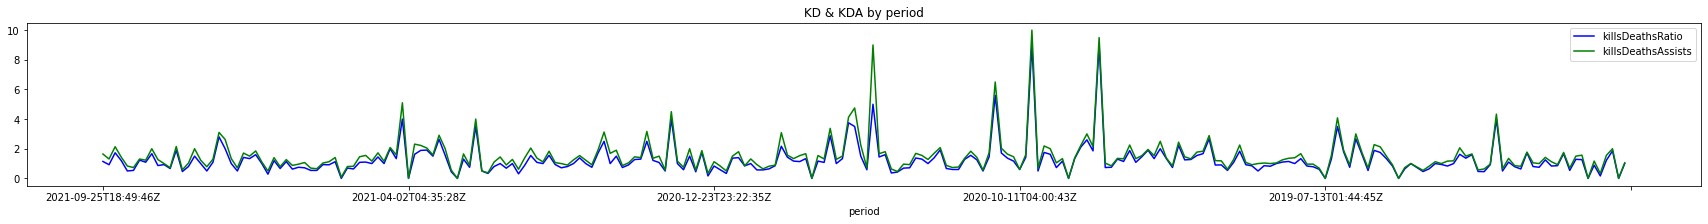

In [11]:
df.plot.line(
    x="period",
    y=["killsDeathsRatio", "killsDeathsAssists"],
    color=["blue", "green"],
    figsize=(30, 3),
    title=f"KD & KDA by period",
)


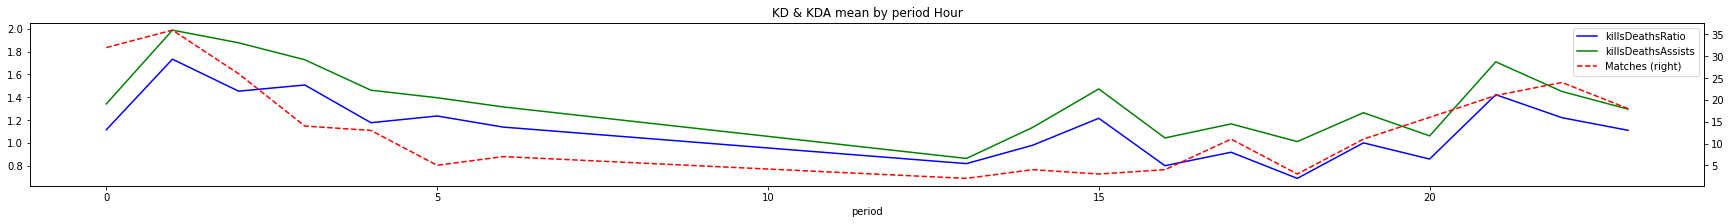

In [12]:
fig, ax = plt.subplots()

df_tmp = df.copy()
df_tmp.period = pd.to_datetime(df_tmp.period)
df_tmp_size = df_tmp.groupby(by=[df_tmp.period.dt.hour]).size()
df_tmp = df_tmp.groupby(by=[df_tmp.period.dt.hour]).mean()
df_tmp.plot.line(
    ax=ax,
    y=["killsDeathsRatio", "killsDeathsAssists"],
    color=["blue", "green"],
    figsize=(30, 3),
    title=f"KD & KDA mean by period Hour",
)
df_tmp_size.plot.line(
    ax=ax, style=["r--"], secondary_y=True, legend=True, label="Matches"
)

del df_tmp, df_tmp_size

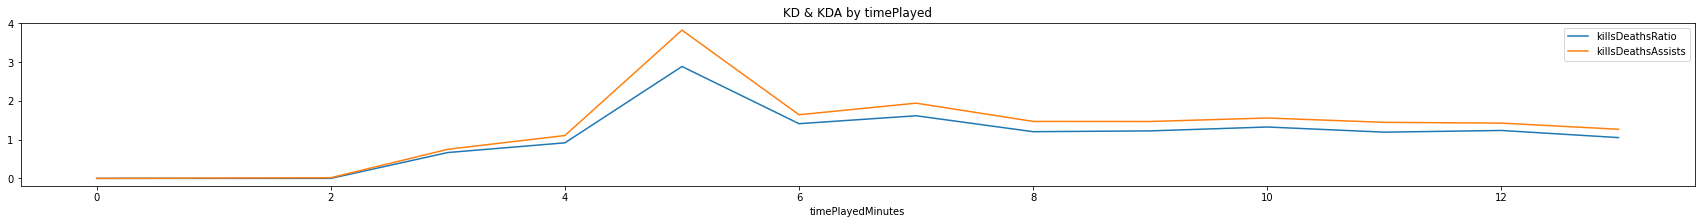

In [13]:
df_tmp = df.copy().sort_values(by=["timePlayedSeconds"])
df_tmp["timePlayedMinutes"] = df_tmp["timePlayedSeconds"] // 60
df_tmp = df_tmp.groupby(by="timePlayedMinutes").mean()
df_tmp.plot.line(
    y=["killsDeathsRatio", "killsDeathsAssists"],
    figsize=(30, 3),
    title=f"KD & KDA by timePlayed",
)

del df_tmp

<AxesSubplot:title={'center':'KD & KDA by period'}, xlabel='period'>

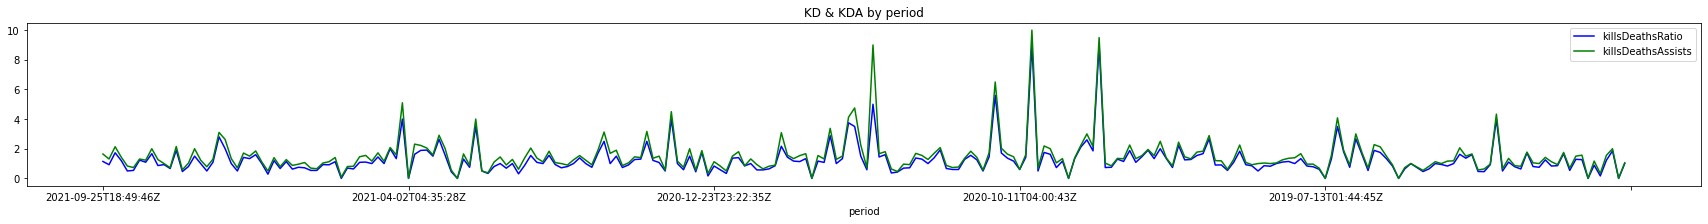

In [14]:
df.plot.line(
    x="period",
    y=["killsDeathsRatio", "killsDeathsAssists"],
    color=["blue", "green"],
    figsize=(30, 3),
    title=f"KD & KDA by period",
)
# TODO: Comparação de KD & KDA por Periodo, com Media diaria ou semanal.

# fig, ax = plt.subplots()

# df_tmp = df.copy()
# df_tmp.period = pd.to_datetime(df_tmp.period)
# df_tmp = df_tmp.sort_values(by=["period"])
# df_tmp.plot.line(
#     ax=ax,
#     x="period",
#     y=["killsDeathsRatio", "killsDeathsAssists"],
#     color=["blue", "green"],
#     figsize=(30, 3),
#     title=f"KD & KDA by period",
# )
# by = [df_tmp.period.dt.day, df_tmp.period.dt.month, df_tmp.period.dt.year]
# df_tmp_size = df_tmp.groupby(by=by).size()
# df_tmp = df_tmp.groupby(by=by).mean()
# df_tmp_size.plot.line(
#     ax=ax, style=["r--"], secondary_y=True, legend=True, label="Matches"
# )

# del df_tmp
